# Análisis por Período

#### Condiciones Iniciales:
 - Los Relevamientos se obtienen en varios csv
 - Debido al tiempo que se requiere para correr el scrapping puede que haya dos fechas para el mismo período (ponemos a correr el scrapper el 28 a la noche y termina el 29 a la mañana)
 - Los datos se guardan en una carpeta nombrada como le fecha del relevamiento (Ej: 20180928)
 - Internamente se guardan diversos csv que provienen de la estructura de scrapping que tenemos, todos cnon la misma estructura
 
#### Objetivo:

Un notebook que, a partir de fecha_inicio y fecha_fin, lea las carpetas de dicha fecha, levante los csv y realice comparativas de precios desde el inicio del periodo al fin del mismo.

#### Parámetros

In [1]:
fecha_inicio_relevamiento = "20180928" # Las fecha debe coincidir con nombres de carpetas
fecha_fin_relevamiento = "20181101" # Las fecha debe coincidir con nombres de carpetas

provincia_relevamiento = "AR-X" # Córdoba

sup_titulo_relevamiento = "Precios Septiembre/Octubre '18"
titulo_relevamiento = "Relevamiento del Programa Precios Claros hecho por @opendatacba, para la provincia de Córdoba."


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,6)

In [3]:
def obtener_path_archivos_de_precios(fecha):
    """Funcion para obtener el listado de archivos csv que almacenan los precios para el relevamiento
    hecho en la fecha pasada por parámetro"""
    
    files_to_read = []
    root_precios = os.path.join(".","datasets","precios", fecha)
    for root, dirs, files in os.walk(root_precios):
        for fname in files:
            files_to_read.append(os.path.join(root, fname))
            
    return(files_to_read)

In [4]:
def obtener_dataset_relevamiento(fecha, inicio_periodo):
    """Funcion que lee la carpeta correspondiente y devuelve un dataframe 
    conteniendo los datos del producto, del establecimiento relevado, el precio
    relevado y la fecha del relevamiento"""
        
    path_archivos_datos = obtener_path_archivos_de_precios(fecha)
    columnas_a_leer = ["fecha_relevamiento", "precio", "producto_id", "sucursal_id"]

    precios = pd.concat((pd.read_csv(f, low_memory=False, usecols=columnas_a_leer, parse_dates=[0]) for f in path_archivos_datos))

    precios = precios[precios["precio"].notnull()]

    # Piso la fecha en la cual se ejecuto el scrapper por la fecha del relevamiento (ver consideraciones)
    precios["fecha_relevamiento"] = pd.to_datetime(fecha)
    
    if inicio_periodo:
        precios.rename({"fecha_relevamiento":"fecha_relevamiento_inicio_periodo","precio": "precio_inicio_periodo"}, axis="columns", inplace=True)
    else:
        precios.rename({"fecha_relevamiento":"fecha_relevamiento_fin_periodo","precio": "precio_fin_periodo"}, axis="columns", inplace=True)   
    
    return(precios)

## Armar dataset comparativo para el Período

#### Cargar datasets de precios y comparar periodos

In [5]:
df_inicio = obtener_dataset_relevamiento(fecha_inicio_relevamiento, inicio_periodo=True)
df_fin = obtener_dataset_relevamiento(fecha_fin_relevamiento, inicio_periodo=False)

df_precios = df_inicio.merge(df_fin, left_on=["producto_id", "sucursal_id"], right_on=["producto_id", "sucursal_id"])
df_precios = df_precios[["producto_id", "sucursal_id", "precio_inicio_periodo", "precio_fin_periodo"]]
df_precios["variacion_periodo"] = round((df_precios["precio_fin_periodo"] / df_precios["precio_inicio_periodo"]) - 1,2)

#### Merge con datasets de Productos

In [6]:
productos = pd.read_csv("./datasets/productos.csv")
productos = productos.drop_duplicates() # El csv tiene muchos duplicados
df_precios = df_precios.merge(productos, left_on="producto_id", right_on="id")

df_precios["nombre"] = df_precios["nombre"].astype("category")
df_precios["marca"] = df_precios["marca"].astype("category")
df_precios["presentacion"] = df_precios["presentacion"].astype("category")
df_precios.drop("id", axis="columns", inplace=True)

#### Merge con datasets de Sucursales y filtrar por Córdoba

In [7]:
sucursales = pd.read_csv("./datasets/sucursales.csv")
sucursales = sucursales[sucursales.provincia == provincia_relevamiento]
sucursales['sucursal_id'] = sucursales.apply(lambda x: f"{x['comercioId']}-{x['banderaId']}-{x['sucursalId']}", axis=1)

cadenas = pd.read_csv('./datasets/cadenas.csv', usecols=['comercioId', 'banderaId', 'comercioRazonSocial', 'banderaDescripcion'])
cadenas.rename(dict(zip(cadenas.columns[-2:], ['empresa', 'cadena'])), inplace=True, axis="columns")
sucursales = pd.merge(sucursales, cadenas, on=['comercioId', 'banderaId'])
sucursales.drop(['provincia', 'sucursalId', 'comercioId', 'banderaId', "lat", "lng"], axis="columns", inplace=True)
sucursales.head()

df_precios = df_precios.merge(sucursales)

#### Inspeccion final

In [8]:
df_precios.head()

,producto_id,sucursal_id,precio_inicio_periodo,precio_fin_periodo,variacion_periodo,nombre,marca,presentacion,localidad,sucursalNombre,direccion,sucursalTipo,empresa,cadena
0,7792900807515,16-1-102,321.99,360.99,0.12,Aceite Oliva Extra Virgen Gourmet Altavia 1 Lt,ALTAVIA,1.0 lt,Capital,Hipermercado Poeta Lugones,Fray Luis Beltrán Y Manuel Cardeñosa None,Hipermercado,Libertad S.A,Hipermercado Libertad
1,7790272000534,16-1-102,207.99,260.99,0.25,Aceite Oliva Extra Virgen Intenso Natura 500 Ml,NATURA,500.0 ml,Capital,Hipermercado Poeta Lugones,Fray Luis Beltrán Y Manuel Cardeñosa None,Hipermercado,Libertad S.A,Hipermercado Libertad
2,7790139004576,16-1-102,271.99,271.99,0.00,Aceite Oliva Extra Virgen Medio Casalta 400 Ml,CASALTA,400.0 ml,Capital,Hipermercado Poeta Lugones,Fray Luis Beltrán Y Manuel Cardeñosa None,Hipermercado,Libertad S.A,Hipermercado Libertad
3,7792070001652,16-1-102,94.99,94.99,0.00,Aceite Oliva Extra Virgen en Botella Nucete 25...,NUCETE,250.0 cc,Capital,Hipermercado Poeta Lugones,Fray Luis Beltrán Y Manuel Cardeñosa None,Hipermercado,Libertad S.A,Hipermercado Libertad
4,7792070001614,16-1-102,230.99,230.99,0.00,Aceite Oliva Extra Virgen en Botella Nucete 50...,NUCETE,500.0 cc,Capital,Hipermercado Poeta Lugones,Fray Luis Beltrán Y Manuel Cardeñosa None,Hipermercado,Libertad S.A,Hipermercado Libertad


### Analisis

In [9]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,6)

In [10]:
# Si queremos leer desde el csv limpio
# columnas_categoricas = ['producto_id', 'sucursal_id', 'nombre', 'marca', 'presentacion', 'localidad', 'sucursalTipo', 'empresa', 'cadena']
# tipo_columnas = ['category'] * len(columnas_categoricas)
# col_types = dict(zip(columnas_categoricas, tipo_columnas))
# df_precios = pd.read_csv("./datasets/analisis/cordoba_mes_de_septiembre.csv", low_memory=False, dtype=col_types)

In [11]:
# Sacamos outliers
# df_precios = df_precios[(df_precios.variacion_periodo > -0.20) & (df_precios.variacion_periodo < 0.30)]

In [12]:
df_precios.variacion_periodo.describe()

count    43437.000000
mean         0.079592
std          0.150940
min         -0.610000
25%          0.000000
50%          0.000000
75%          0.140000
max          1.600000
Name: variacion_periodo, dtype: float64

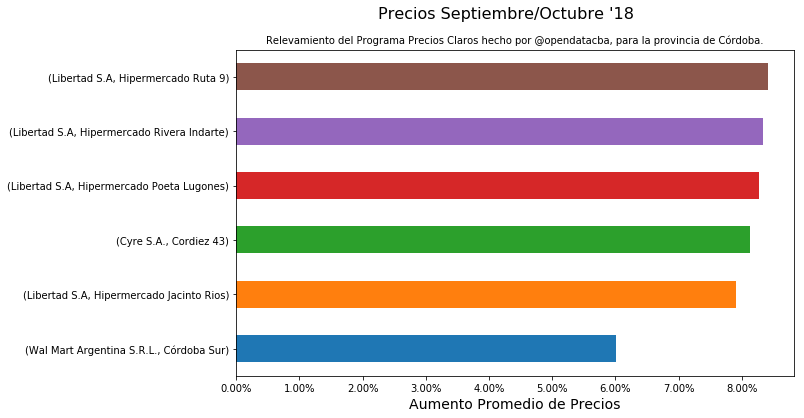

In [13]:
ax = df_precios.groupby(["empresa","sucursalNombre"])["variacion_periodo"].mean().sort_values().plot(kind="barh")
vals = ax.get_xticks()
ax.set_xticklabels(['{:,.2%}'.format(x) for x in vals])
plt.suptitle(sup_titulo_relevamiento, size=16)
plt.title(titulo_relevamiento, size=10)
plt.ylabel("")
plt.xlabel("Aumento Promedio de Precios", size=14)
plt.show()

In [14]:
df_precios.groupby(["empresa","sucursalNombre"])["variacion_periodo"].mean().sort_values(ascending=False)

empresa                    sucursalNombre             
Libertad S.A               Hipermercado Ruta 9            0.084043
                           Hipermercado Rivera Indarte    0.083274
                           Hipermercado Poeta Lugones     0.082652
Cyre S.A.                  Cordiez 43                     0.081297
Libertad S.A               Hipermercado Jacinto Rios      0.079121
Wal Mart Argentina S.R.L.  Córdoba Sur                    0.060125
Name: variacion_periodo, dtype: float64

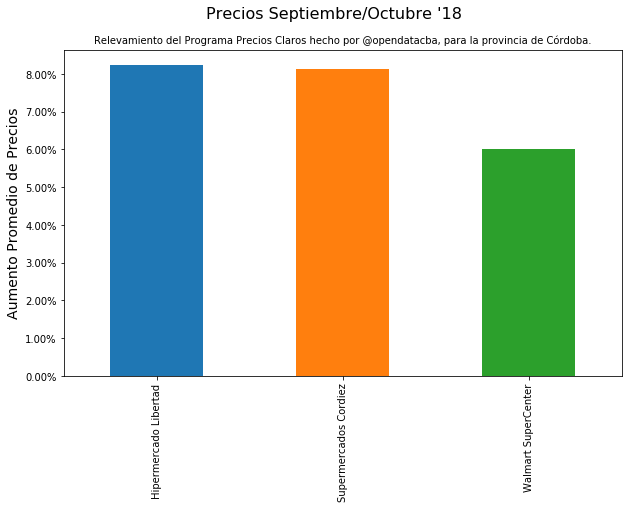

In [15]:
ax = df_precios.groupby(["cadena"])["variacion_periodo"].mean().sort_values(ascending=False).plot(kind="bar")
plt.suptitle(sup_titulo_relevamiento, size=16)
plt.title(titulo_relevamiento, size=10)
plt.xlabel("")
plt.ylabel("Aumento Promedio de Precios", size=14)
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
plt.show()

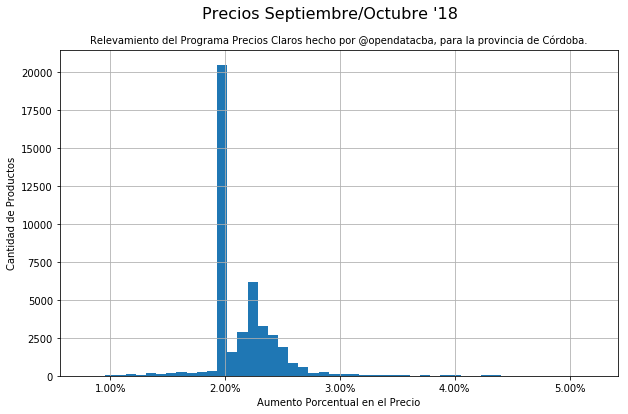

In [16]:
ax = df_precios.variacion_periodo.hist(bins=50)
plt.suptitle(sup_titulo_relevamiento, size=16)
plt.title(titulo_relevamiento, size=10)
plt.ylabel("Cantidad de Productos")
plt.xlabel("Aumento Porcentual en el Precio")
ax.set_xticklabels(['{:,.2%}'.format(x) for x in vals])
plt.show()

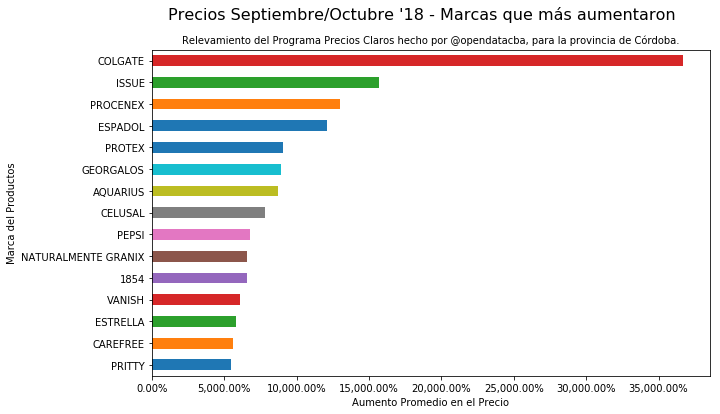

In [17]:
aumentos_marcas = df_precios.groupby("marca")["variacion_periodo"].agg({"mean", "count"}).sort_values(ascending=False, by="mean")
# Nos aseguramos que haya suficientes precios relevados como para que sea representativo el promedio
aumentos_marcas = aumentos_marcas[aumentos_marcas["count"] > 50]
aumentos_marcas.columns = ["aumento_promedio", "cantidad_precios_relevados"]

ax = aumentos_marcas.aumento_promedio.head(15).sort_values().plot(kind="barh")
vals = ax.get_xticks()
ax.set_xticklabels(['{:,.2%}'.format(x) for x in vals])
plt.suptitle(sup_titulo_relevamiento + " - Marcas que más aumentaron", size=16)
plt.title(titulo_relevamiento, size=10)
plt.ylabel("Marca del Productos")
plt.xlabel("Aumento Promedio en el Precio")
plt.show()

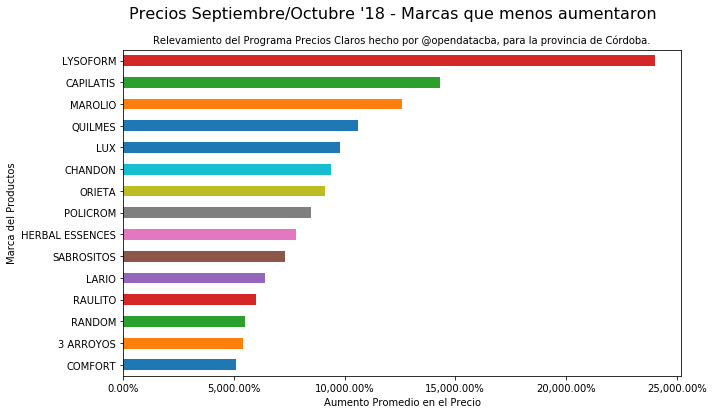

In [18]:
ax = aumentos_marcas.aumento_promedio.tail(15).sort_values().plot(kind="barh")
vals = ax.get_xticks()
ax.set_xticklabels(['{:,.2%}'.format(x) for x in vals])
plt.suptitle(sup_titulo_relevamiento + " - Marcas que menos aumentaron", size=16)
plt.title(titulo_relevamiento, size=10)
plt.ylabel("Marca del Productos")
plt.xlabel("Aumento Promedio en el Precio")
plt.show()

## Analisis Productos

In [19]:
def graficar_variacion_producto(df_producto, sup_title_producto):
    ax = df_producto["mean"].plot(kind="barh")
    vals = ax.get_xticks()
    ax.set_xticklabels(['{:,.2%}'.format(x) for x in vals])
    plt.suptitle(sup_titulo_relevamiento + " - " + sup_title_producto, size=16)
    plt.title(titulo_relevamiento, size=10)
    plt.ylabel("")
    plt.xlabel("Aumento Promedio en el Precio", size=12)
    plt.show()

### Análisis Harinas

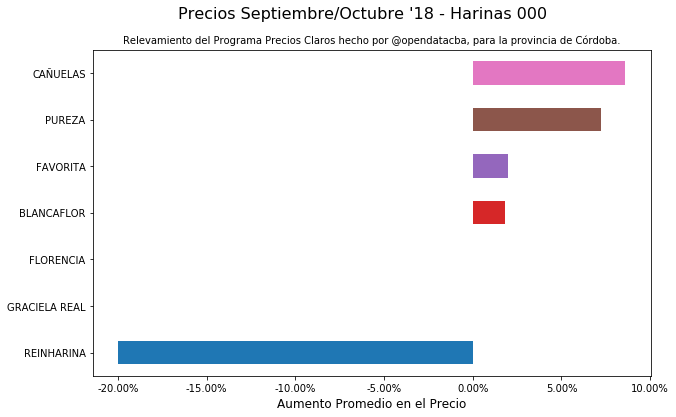

In [20]:
df_harinas = df_precios[df_precios.nombre.str.contains("Harina de Trigo 000")] \
    .groupby("marca", observed=True)["variacion_periodo"] \
    .agg({"mean","count"})\
    .sort_values(by="mean")

graficar_variacion_producto(df_harinas, "Harinas 000")

### Relevamiento Fideos

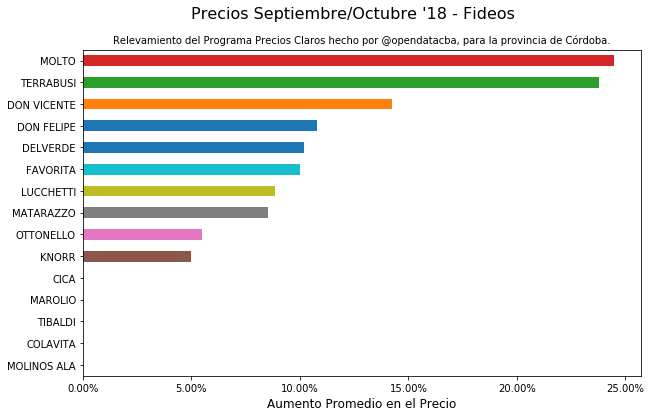

In [21]:
df_fideos = df_precios[df_precios.nombre.str.contains("Fideos")] \
    .groupby("marca", observed=True)["variacion_periodo"] \
    .agg({"mean","count"})\
    .sort_values(by="mean")

df_fideos = df_fideos[df_fideos["count"] > 10]

graficar_variacion_producto(df_fideos, "Fideos")

### Relevamiento Aceite

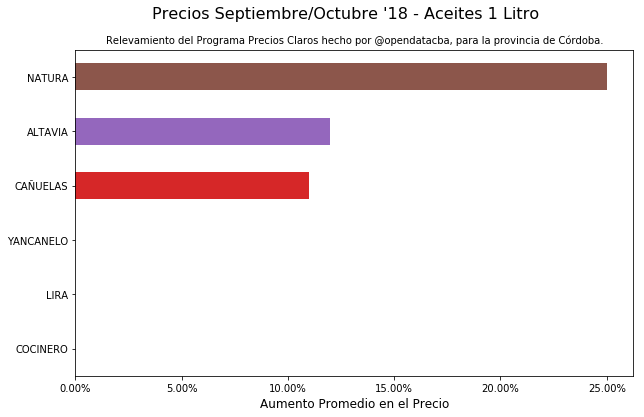

In [22]:
mask_aceites = df_precios.nombre.str.contains("Aceite")
mask_presentacion = df_precios.presentacion.str.contains("1.0 lt")

df_aceites = df_precios[mask_aceites & mask_presentacion] \
    .groupby("marca", observed=True)["variacion_periodo"] \
    .agg({"mean","count"})\
    .sort_values(by="mean")

graficar_variacion_producto(df_aceites, "Aceites 1 Litro")

### Relevamiento Azúcar

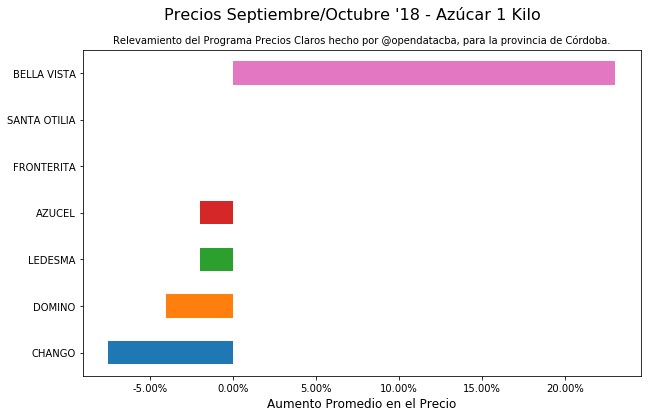

In [23]:
mask_azucar = df_precios.nombre.str.contains("^Azucar")
mask_presentacion_azucar = df_precios.presentacion.str.contains("1.0 kg")

df_azucar = df_precios[mask_azucar & mask_presentacion_azucar] \
    .groupby("marca", observed=True)["variacion_periodo"] \
    .agg({"mean","count"})\
    .sort_values(by="mean")
    
graficar_variacion_producto(df_azucar, "Azúcar 1 Kilo")

### Relevamiento Yerba

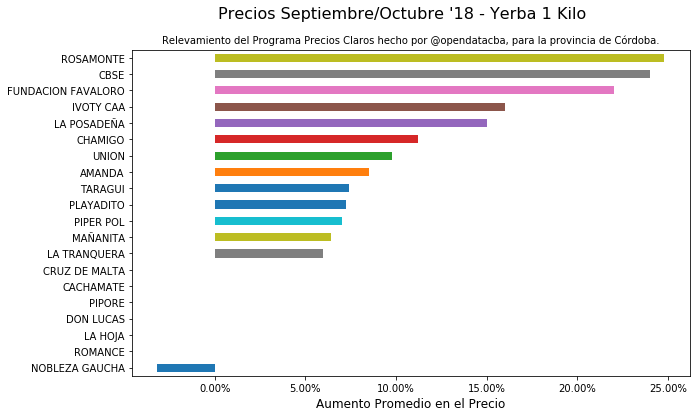

In [24]:
mask_azucar = df_precios.nombre.str.contains("^Yerba")
mask_presentacion_azucar = df_precios.presentacion.str.contains("1.0 kg")

df_yerba = df_precios[mask_azucar & mask_presentacion_azucar] \
    .groupby("marca", observed=True)["variacion_periodo"] \
    .agg({"mean","count"})\
    .sort_values(by="mean")
    
graficar_variacion_producto(df_yerba, "Yerba 1 Kilo")

### Relevamiento Leche

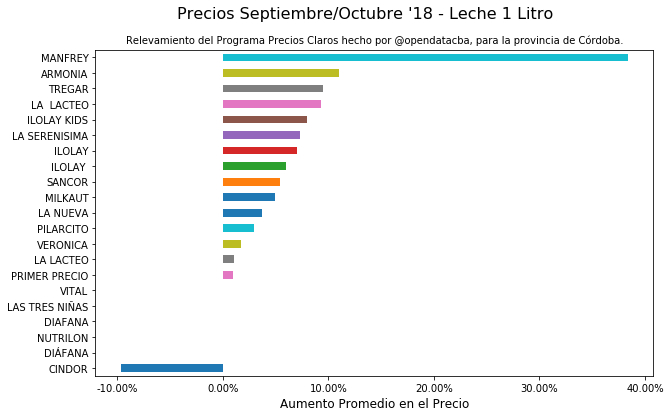

In [25]:
mask_leche = df_precios.nombre.str.contains("^Leche")
mask_presentacion_leche = df_precios.presentacion.str.contains("1.0 lt")

df_leche = df_precios[mask_leche & mask_presentacion_leche] \
    .groupby("marca", observed=True)["variacion_periodo"] \
    .agg({"mean","count"})\
    .sort_values(by="mean")
    
graficar_variacion_producto(df_leche, "Leche 1 Litro")

### Relevamiento Arroz

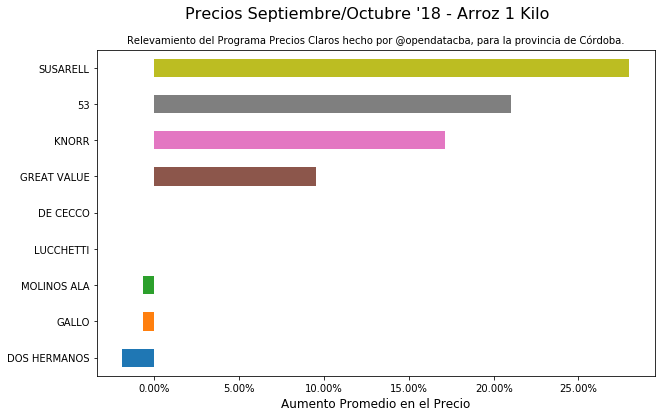

In [26]:
mask_arroz = df_precios.nombre.str.contains("^Arroz")
mask_presentacion_arroz = df_precios.presentacion.str.contains("1.0 kg")

df_arroz = df_precios[mask_arroz & mask_presentacion_arroz] \
    .groupby("marca", observed=True)["variacion_periodo"] \
    .agg({"mean","count"})\
    .sort_values(by="mean")
    
graficar_variacion_producto(df_arroz, "Arroz 1 Kilo")

### Relevamiento Fernet

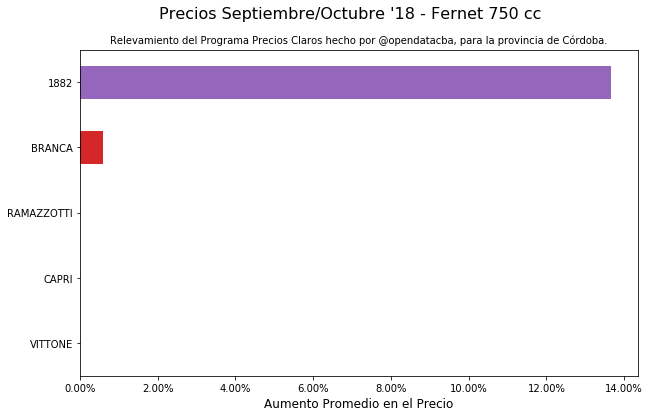

In [27]:
mask_fernet = df_precios.nombre.str.contains("^Fernet")
mask_presentacion_fernet = df_precios.presentacion.str.contains("750.0 cc")

df_fernet = df_precios[mask_fernet & mask_presentacion_fernet] \
    .groupby("marca", observed=True)["variacion_periodo"] \
    .agg({"mean","count"})\
    .sort_values(by="mean")
    
graficar_variacion_producto(df_fernet, "Fernet 750 cc")

## Tabla Comparativa Aumento Productos

In [28]:
df_harinas["producto"] = "Harinas"
df_aceites["producto"] = "Aceites"
df_fideos["producto"] = "Fideos"
df_azucar["producto"] = "Azucar"
df_yerba["producto"] = "Yerba"
df_leche["producto"] = "Leche"
df_arroz["producto"] = "Arroz"
df_fernet["producto"] = "Fernet"

df_productos = pd.concat([df_harinas, df_aceites, df_fideos, df_azucar, df_yerba, df_leche, df_arroz, df_fernet])

df_productos.groupby("producto")["mean"].agg({"mean", "min", "max"}).sort_values(by="mean", ascending=False)

,max,min,mean
producto,,,
Yerba,0.248000,-0.031667,0.081075
Fideos,0.245000,0.000000,0.080939
Arroz,0.280000,-0.019091,0.080432
Aceites,0.250000,0.000000,0.080000
Leche,0.384000,-0.096667,0.051290
Fernet,0.136667,0.000000,0.028533
Azucar,0.230000,-0.075000,0.010714
Harinas,0.086000,-0.200000,-0.000500


## Dispersion de Precios

¿Cuán dispersos son los precios de un mismo producto en los supermercados e hipermercados de Córdoba?

### Diferencia Básica

¿Qué porcentaje de productos tienen variación de precio en la Provincia? Me interesa solamente si el producto X tiene distinto precio en distintos establecimientos.

In [29]:
sample_suc_cba_capital = ["Cordoba Donato Alvarez", "Córdoba Sur", "Hipermercado Poeta Lugones", "Mini Libertad Colon", "Mini Libertad Rondeau", "Mini Libertad Tucuman", "Mini Libertad Sagrada Familia", "Córdoba Granaderos", "Mini Libertad Nueva Cordoba"]

df_variacion_basica = df_precios[df_precios["empresa"] == "Libertad S.A"] \
    .groupby(["producto_id", "nombre"])["precio_fin_periodo"] \
    .agg({"count","min","max", "std"})

df_variacion_basica["diferencia_precio_max_min"] = df_variacion_basica["max"] - df_variacion_basica["min"]
df_variacion_basica["hay_diferencia"] = df_variacion_basica["diferencia_precio_max_min"] != 0.0
df_variacion_basica = df_variacion_basica[df_variacion_basica["count"] > 5]

df_variacion_basica.hay_diferencia.value_counts()

Series([], Name: hay_diferencia, dtype: int64)

In [30]:
1784 / (1784 + 52)

0.971677559912854

In [31]:
df_precios[df_precios.localidad == "Capital"].empresa.unique()

array(['Libertad S.A'], dtype=object)

In [32]:
df_variacion_basica[df_variacion_basica.hay_diferencia == True]

,,count,std,max,min,diferencia_precio_max_min,hay_diferencia
producto_id,nombre,,,,,,


In [33]:
df_variacion_basica[df_variacion_basica.hay_diferencia == False]

,,count,std,max,min,diferencia_precio_max_min,hay_diferencia
producto_id,nombre,,,,,,


In [34]:
pd.Series([1,1,1]).std()

0.0

In [35]:
zscore = lambda x: (x - x.mean()) / x.std()

df_precios["precio_fin_periodo_normalized"] = df_precios.groupby(["producto_id", "nombre"])["precio_fin_periodo"].transform(zscore)

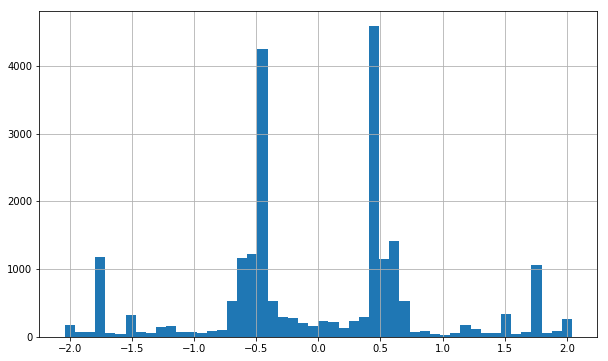

In [36]:
df_precios["precio_fin_periodo_normalized"].hist(bins=50)

In [37]:
my_range = lambda x: x.max() - x.min()

df_dispersion = df_precios.groupby(["producto_id", "nombre"])["precio_fin_periodo_normalized"].agg(my_range)

df_dispersion.sort_values(ascending=False).head()

producto_id    nombre                                                         
7794940000796  Edulcorante Liquido Hileret Zucra 200 Cc                           3.455048
7891150023505  Shampoo 2 en 1 Fuerza Extrema Dove Men 400 Ml                      3.162256
7790742104205  Dulce de Leche Colonial La Serenisima 250 Gr                       3.162245
7790150100752  Cafe Instantaneo Torrado Clasico Equilibrado La Virginia 100 Gr    3.162237
7790520009340  Limpiador Liquido Floral Mr Musculo 1.8 Lt                         3.162218
Name: precio_fin_periodo_normalized, dtype: float64

In [38]:
df_precios[df_precios.producto_id == "7798108830201"] 

,producto_id,sucursal_id,precio_inicio_periodo,precio_fin_periodo,variacion_periodo,nombre,marca,presentacion,localidad,sucursalNombre,direccion,sucursalTipo,empresa,cadena,precio_fin_periodo_normalized
280,7798108830201,16-1-102,118.99,118.99,0.00,Vino Tinto Syrah Alta Callia 750 Cc,CALLIA,750.0 cc,Capital,Hipermercado Poeta Lugones,Fray Luis Beltrán Y Manuel Cardeñosa None,Hipermercado,Libertad S.A,Hipermercado Libertad,0.447214
9185,7798108830201,16-1-602,118.99,118.99,0.00,Vino Tinto Syrah Alta Callia 750 Cc,CALLIA,750.0 cc,Capital,Hipermercado Ruta 9,Avda. Amadeo Sabattini 3250,Hipermercado,Libertad S.A,Hipermercado Libertad,0.447214
17718,7798108830201,16-1-2502,118.99,118.99,0.00,Vino Tinto Syrah Alta Callia 750 Cc,CALLIA,750.0 cc,Capital,Hipermercado Rivera Indarte,Av.Ricardo Rojas Y Manuel De Falla None,Hipermercado,Libertad S.A,Hipermercado Libertad,0.447214
26167,7798108830201,16-1-202,118.99,118.99,0.00,Vino Tinto Syrah Alta Callia 750 Cc,CALLIA,750.0 cc,Capital,Hipermercado Jacinto Rios,Libertad 1100,Hipermercado,Libertad S.A,Hipermercado Libertad,0.447214
34275,7798108830201,11-5-1010,119.00,101.15,-0.15,Vino Tinto Syrah Alta Callia 750 Cc,CALLIA,750.0 cc,CIUDAD DE CORDOBA NORTE,Córdoba Sur,Av Circunvalacion Este 2557,Hipermercado,Wal Mart Argentina S.R.L.,Walmart SuperCenter,-1.788854


In [39]:
def my_zscore(col):
    return (col - col.mean()) / col.std()
    
df_precios.groupby(["producto_id", "nombre"])["precio_fin_periodo"].apply(my_zscore)

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
5             NaN
6             NaN
7             NaN
8             NaN
9             NaN
10            NaN
11      -0.447214
12       0.707107
13      -0.500000
14            NaN
15      -0.500000
16            NaN
17      -0.447214
18            NaN
19      -0.447214
20      -0.447214
21            NaN
22      -0.447214
23       0.554208
24       0.447214
25      -0.447214
26      -0.465353
27       0.577350
28      -0.640135
29      -0.447214
           ...   
43407         NaN
43408         NaN
43409         NaN
43410         NaN
43411         NaN
43412         NaN
43413         NaN
43414         NaN
43415         NaN
43416         NaN
43417         NaN
43418         NaN
43419         NaN
43420         NaN
43421         NaN
43422         NaN
43423         NaN
43424         NaN
43425         NaN
43426         NaN
43427         NaN
43428         NaN
43429         NaN
43430         NaN
43431     